In [5]:
library(bbmle)
library(tidyverse)
library(deSolve)
dev.new(width=8, height=3.5)

ERROR: Error in library(tidyverse): there is no package called 'tidyverse'


In [4]:
install.packages('tidyverse')

also installing the dependencies 'processx', 'xfun', 'lifecycle', 'tidyselect', 'vctrs', 'scales', 'gargle', 'timechange', 'systemfonts', 'vroom', 'callr', 'knitr', 'glue', 'broom', 'conflicted', 'cli', 'dbplyr', 'dplyr', 'dtplyr', 'forcats', 'ggplot2', 'googledrive', 'googlesheets4', 'haven', 'hms', 'jsonlite', 'lubridate', 'magrittr', 'modelr', 'pillar', 'purrr', 'ragg', 'readr', 'readxl', 'reprex', 'rlang', 'rvest', 'stringr', 'tibble', 'tidyr', 'xml2'




  There are binary versions available but the source versions are later:
              binary source needs_compilation
processx       3.5.2  3.8.1              TRUE
xfun            0.22   0.39              TRUE
lifecycle      1.0.0  1.0.3             FALSE
tidyselect     1.1.1  1.2.0             FALSE
vctrs          0.3.8  0.6.2              TRUE
scales         1.1.1  1.2.1             FALSE
gargle         1.1.0  1.4.0             FALSE
timechange     0.0.2  0.2.0              TRUE
systemfonts    1.0.2  1.0.4              TRUE
vroom          1.4.0  1.6.3              TRUE
callr          3.7.0  3.7.3             FALSE
knitr           1.33   1.42             FALSE
glue           1.4.2  1.6.2              TRUE
broom          0.7.6  1.0.4             FALSE
conflicted     1.0.4  1.2.0             FALSE
cli            2.5.0  3.6.1              TRUE
dbplyr         2.1.1  2.3.2             FALSE
dplyr          1.0.6  1.1.2              TRUE
dtplyr         1.1.0  1.3.1             FALSE
forcat

Warning message:
"cannot remove prior installation of package 'jsonlite'"Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying D:\Anaconda\envs\myenv\lib\R\library\00LOCK\jsonlite\libs\x64\jsonlite.dll to D:\Anaconda\envs\myenv\lib\R\library\jsonlite\libs\x64\jsonlite.dll: Permission denied"Warning message:
"restored 'jsonlite'"

package 'lubridate' successfully unpacked and MD5 sums checked
package 'magrittr' successfully unpacked and MD5 sums checked
package 'purrr' successfully unpacked and MD5 sums checked
package 'ragg' successfully unpacked and MD5 sums checked
package 'readr' successfully unpacked and MD5 sums checked
package 'readxl' successfully unpacked and MD5 sums checked
package 'rlang' successfully unpacked and MD5 sums checked
package 'tibble' successfully unpacked and MD5 sums checked
package 'tidyr' successfully unpacked and MD5 sums checked
package 'xml2' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\joely\AppData\Local\Temp\RtmpaA1pG6\downloaded_packages


installing the source packages 'lifecycle', 'tidyselect', 'scales', 'gargle', 'callr', 'knitr', 'broom', 'conflicted', 'dbplyr', 'dtplyr', 'forcats', 'ggplot2', 'googledrive', 'googlesheets4', 'hms', 'modelr', 'pillar', 'reprex', 'rvest', 'stringr', 'tidyverse'

Warning message in install.packages("tidyverse"):
"installation of package 'lifecycle' had non-zero exit status"Warning message in install.packages("tidyverse"):
"installation of package 'callr' had non-zero exit status"Warning message in install.packages("tidyverse"):
"installation of package 'knitr' had non-zero exit status"Warning message in install.packages("tidyverse"):
"installation of package 'conflicted' had non-zero exit status"Warning message in install.packages("tidyverse"):
"installation of package 'tidyselect' had non-zero exit status"Warning message in install.packages("tidyverse"):
"installation of package 'scales' had non-zero exit status"Warning message in install.packages("tidyverse"):
"installation of package

## Dataset
Using the dataset obtained from Kelley Islands Influenza outbreak in 1920. 

In [2]:
df <- select(data.frame(read.csv('Datasets/Chapter5.csv')), c('days', 'cases'))
plot(df$days, df$cases, xlab='Days', ylab='Incidence', col='red', pch=4, lwd=1.6)
title('Kelley Islands Flu Outbreak 1920')
N <- 689

initial_data <- c(S=N-4, E=4, I=0, R=0)
initial_data

ERROR: Error in select(data.frame(read.csv("Datasets/Chapter5.csv")), c("days", : could not find function "select"


## SEIR Model

$\frac{dS}{dt} = -\frac{\beta{S}{I}}{N}$

$\frac{dE}{dt} = \frac{\beta{S}{I}}{N} - \alpha{E}$

$\frac{dI}{dt} = \alpha {E} - \gamma{I}$

$\frac{dZ}{dt} = \gamma{I}$

In [48]:
model <- function(parameters, initial_conditions, time){
    equations <- function(time, variables, parameters) {
        with(as.list(c(variables, parameters)), {
            N <- S+E+I+R
            dS <- -beta * I * S/N
            dE <- beta * S*I/N - alpha * E
            dI <- alpha*E - gamma*I
            dR <-  gamma * I
            return(list(c(dS, dE, dI, dR)))
        })
    }
    out <- ode(
        y = initial_conditions,
        times = c(0,time),
        func = equations,
        parms = parameters
    )
    return(as.data.frame(out)[-1,])
}

Along with incidence curve generated by: 

$C_I(d) \approx \alpha h[\frac{1}{2}(E(d)+E(d+1)) + \sum_{j=1}^{m-1}{E(t_j)}]$

In [49]:
tau_incidence <- function(params, from, to, n=100){
    time_points <- seq(from, to, 1/n)
    model_data <- model(params, initial_conditions=initial_data, time=time_points)
    model_data$C <- params['beta']*model_data$S*model_data$I/N
    ends <- tail(model_data$C, n=1) + model_data$C[1] 
    total <- sum(model_data$C) - 0.5*ends
    return(1/n*total)
}

In [50]:
incidence_curve <- function(params, times){
    inc_data <- data.frame(time=times[1], incidence=tau_incidence(params, times[1], times[2]))
    for(i in 2:length(times)){
        instant <- tau_incidence(params, times[i-1], times[i])
        inc_data[nrow(inc_data) + 1,] = c(times[i-1], instant)
    }
    return(inc_data)
}

## Least Squares

In [52]:
time_length <- 30
incidence_times <- seq(0, time_length, 0.1)
ss <- function(params){
    predictions <- incidence_curve(params, times = df$days)
    sum((predictions$incidence - df$cases)^2)
}
starting_param_val <- c(beta=1.9, gamma=1.4, alpha=0.5)
ss_optim <- optim(starting_param_val, ss)

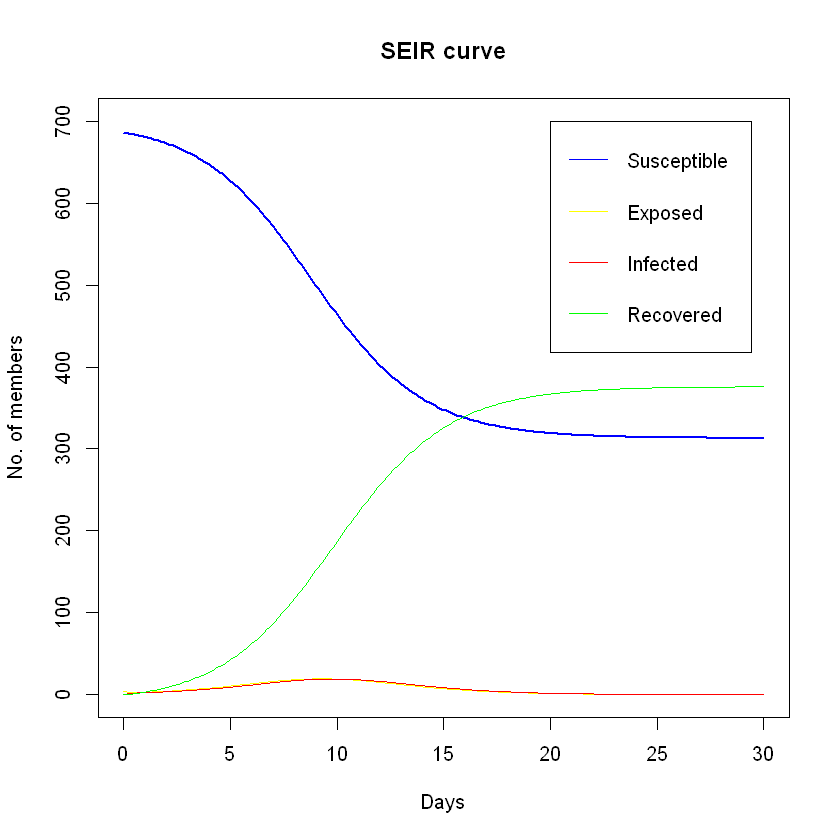

In [53]:
params<- ss_optim$par
times <- seq(0,time_length, 0.1)
data <- model(params, initial_data, times)
plot(loess(data$S~times),type='l', col='blue',  xlab='Days', ylab='No. of members', pch=4, lwd=1.6, ylim=c(0,700))

legend(20, 700, legend=c("Susceptible", "Exposed", "Infected", "Recovered"), col=c("blue", "yellow", "red","green"),
       lty=1, y.intersp=2)
lines(loess(data$E~times), type='l',col='yellow')
lines(loess(data$I~times),type='l', col='red' )
lines(loess(data$R~times),type='l', col='green')

title('SEIR curve')

In [54]:
params

beta    gamma    alpha 
2.723836 1.897784 1.897616

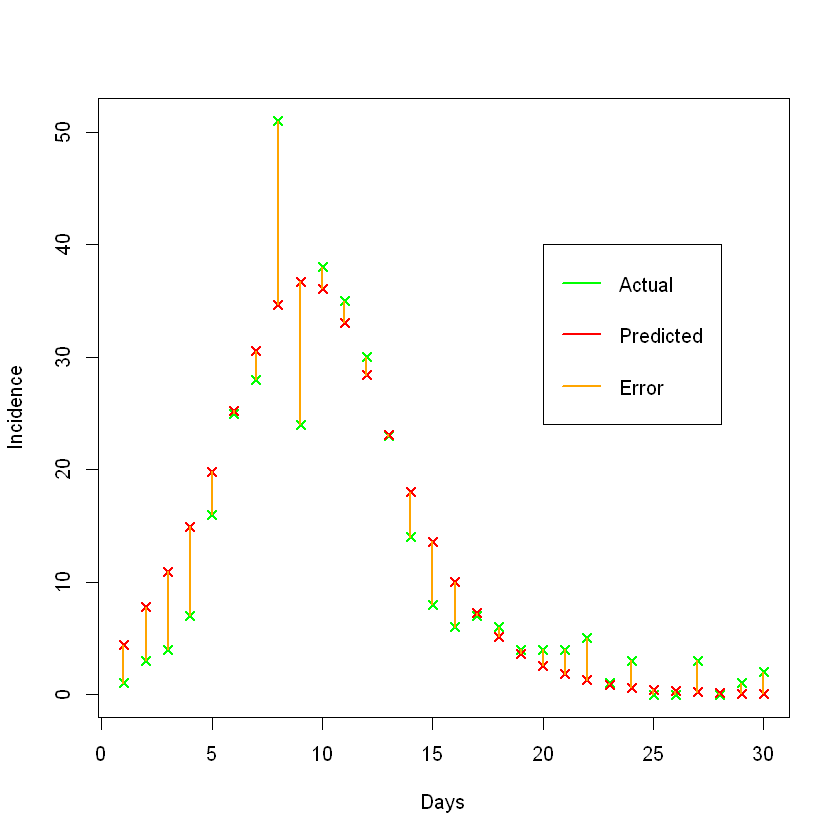

In [65]:
inc_data <- incidence_curve(params=params, times=seq(0,30))
plot(df$days, df$cases, xlab='Days', ylab='Incidence', col='green', pch=4, lwd=1.6)
points(df$days, inc_data[-1,]$incidence, col='red', pch=4, lwd=1.6)
legend(20, 40, legend=c("Actual", "Predicted", "Error"), col=c("green", "red", "orange"), lty=1:1,lwd=1.6, y.intersp=2)
arrows(df$days, df$cases,df$days, inc_data[-1,]$incidence, length=0.1, angle=90, code=0, col='orange', lwd=1.7)

## SIR Model
The SEIR model gave unrealistic results (the best fit parameters were outside of sensible bounds). We try fitting to an SIR model with incidence

In [6]:
sir_model <- function(beta, gamma, initial_conditions, times){
    equations <- function(time, variables, parameters) {
        with(as.list(c(variables, parameters)), {
            N <- X+Y+Z
            dX <- -beta * X * Y/N
            dY <- beta * X*Y/N - gamma * Y
            dZ <-  gamma * Y
            return(list(c(dX, dY, dZ)))
        })
    }
    out <- ode(
        y = initial_conditions,
        times = c(0,times),
        func = equations,
        parms = c(beta=beta, gamma=gamma) 
    )
    # Always have to pass t=0 state to ode solver as it gets it's IC from t=0.
    return(as.data.frame(out)[-1,])
}
sir_initial_data <- c(S=N-4, I=4, R=0)


ERROR: Error in eval(expr, envir, enclos): object 'N' not found


In [ ]:
sir_tau_incidence <- function(params, from, to, n=100){
    time_points <- seq(from, to, 1/n)
    model_data <- sir_model(params, initial_conditions=initial_data, time=time_points)
    model_data$C <- params['beta']*model_data$S*model_data$I/N
    ends <- tail(model_data$C, n=1) + model_data$C[1] 
    total <- sum(model_data$C) - 0.5*ends
    return(1/n*total)
}